<a href="https://colab.research.google.com/github/Jvlia17/rodents-classification/blob/main/Rosegador.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ten kod jest poświęcony kodowaniu w ramach pracy magisterskiej skupionej na opracowywaniu niestandardowego zestawu danych do rozpoznawania gryzoni przy użyciu sztucznej inteligencji. W jego ramach wykorzystuje się najnowocześniejsze technologie, różnorodne metody bilansowania danych, dostrojenie hiperparametrów, transfer learning oraz ataki adwersarialne na sieci w celu poprawy odporności i efektywności modelu.

Github: https://github.com/Jvlia17/rodents-classification

# 0. Pobranie bibliotek

In [1]:
# Potrzebne biblioteki

import pathlib
import PIL.Image as Image
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img,img_to_array
from tensorflow.keras.applications import VGG16
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
from imblearn.over_sampling import RandomOverSampler
import random
from PIL import Image

plt.rcParams['font.size']=14

# 1. Pobranie danych

In [4]:
# Usuwanie istniejących folderów

!rm -rf sample_data

# Pobranie danych i wyodrębnienie ich

!wget https://www.dropbox.com/scl/fi/xhgs04km1gn53ebccmjjy/Rosegador.zip?rlkey=pkbd9d125ebb4untz49lv872p&dl=0


--2024-02-26 17:24:56--  https://www.dropbox.com/scl/fi/xhgs04km1gn53ebccmjjy/Rosegador.zip?rlkey=pkbd9d125ebb4untz49lv872p
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc46a4a5f235fc9fd307dbb098b9.dl.dropboxusercontent.com/cd/0/inline/COACzmb8M51EKw90qdUBWyQGLqKSa6M0rHNoHHD9ZRzX1thkGYDnvj7rCDT9DAJQzgb2CgtrYVnLd99Nw9PTVIdC6Erd42U--fql3CHspktcY_9w157RMU7Re-mXRTmuoChp9gQm190lNUJ9w26FMob9/file# [following]
--2024-02-26 17:25:00--  https://uc46a4a5f235fc9fd307dbb098b9.dl.dropboxusercontent.com/cd/0/inline/COACzmb8M51EKw90qdUBWyQGLqKSa6M0rHNoHHD9ZRzX1thkGYDnvj7rCDT9DAJQzgb2CgtrYVnLd99Nw9PTVIdC6Erd42U--fql3CHspktcY_9w157RMU7Re-mXRTmuoChp9gQm190lNUJ9w26FMob9/file
Resolving uc46a4a5f235fc9fd307dbb098b9.dl.dropboxusercontent.com (uc46a4a5f235fc9fd307dbb098b9.dl.dropboxusercontent.com)... 162.125.5.15, 2620:

In [5]:
!unzip /content/Rosegador.zip?rlkey=pkbd9d125ebb4untz49lv872p

Streaming output truncated to the last 5000 lines.
  inflating: Dataset/Capybara/cap (4260).jpg  
  inflating: Dataset/Capybara/cap (4261).jpg  
  inflating: Dataset/Capybara/cap (4262).jpg  
  inflating: Dataset/Capybara/cap (4263).jpg  
  inflating: Dataset/Capybara/cap (4264).jpg  
  inflating: Dataset/Capybara/cap (4265).jpg  
  inflating: Dataset/Capybara/cap (4266).jpg  
  inflating: Dataset/Capybara/cap (4267).jpg  
  inflating: Dataset/Capybara/cap (4268).jpg  
  inflating: Dataset/Capybara/cap (4269).jpg  
  inflating: Dataset/Capybara/cap (427).jpg  
  inflating: Dataset/Capybara/cap (4270).jpg  
  inflating: Dataset/Capybara/cap (4271).jpg  
  inflating: Dataset/Capybara/cap (4272).jpg  
  inflating: Dataset/Capybara/cap (4273).jpg  
  inflating: Dataset/Capybara/cap (4274).jpg  
  inflating: Dataset/Capybara/cap (4275).jpg  
  inflating: Dataset/Capybara/cap (4276).jpg  
  inflating: Dataset/Capybara/cap (4277).jpg  
  inflating: Dataset/Capybara/cap (4278).jpg  
  inflatin

# 2. Przygotowanie danych

## 2.1 Sprawdzenie danych

In [6]:
# Sprawdzenie ilości obrazów w folderach

ROOT_DIR = "/content/Dataset"
number_of_images = {}

for dir in os.listdir(ROOT_DIR):
  number_of_images[dir] = len(os.listdir(os.path.join(ROOT_DIR, dir)))

number_of_images.items()



dict_items([('Mouse', 248), ('Guinea Pig', 1520), ('Rat', 222), ('Chinchillas', 338), ('Capybara', 4930), ('Hamster', 1361)])

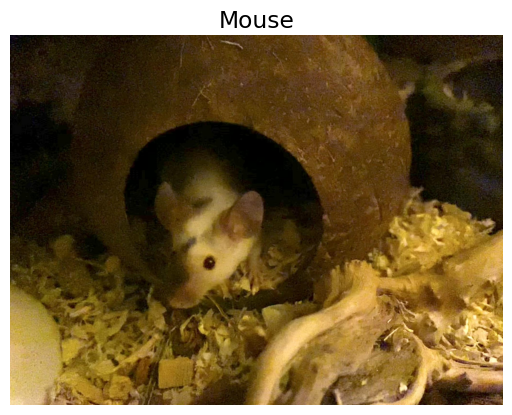

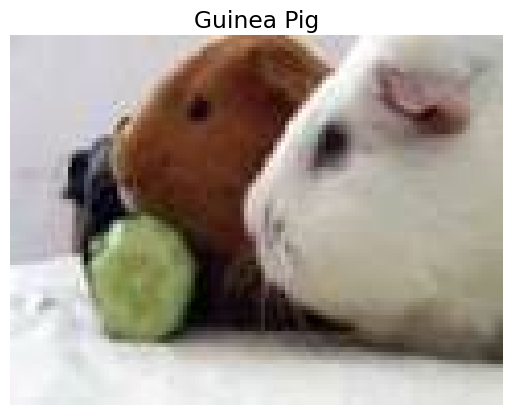

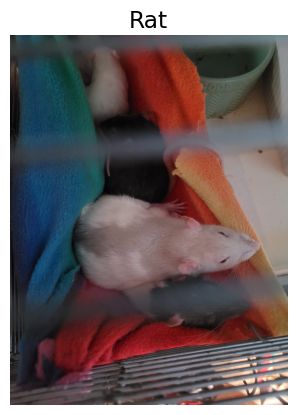

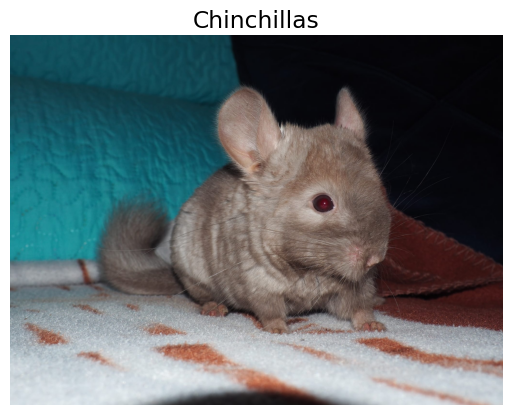

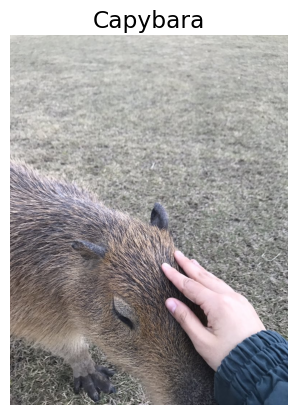

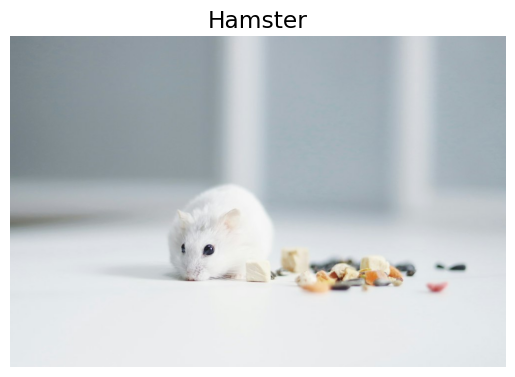

In [11]:
# Wyświetlenie randomowego obrazu z każdego folderu

data_folder = "/content/Dataset"

# Pobierz listę folderów w głównym katalogu
folders = os.listdir(data_folder)

# Iteruj po każdym folderze i wyświetl losowy obraz
for folder in folders:

    # Utwórz pełną ścieżkę do folderu
    folder_path = os.path.join(data_folder, folder)

    # Pobierz listę plików w folderze
    files = os.listdir(folder_path)

    # Wybierz losowy plik z folderu
    random_file = random.choice(files)

    # Utwórz pełną ścieżkę do losowego pliku
    file_path = os.path.join(folder_path, random_file)

    # Wczytaj obraz i wyświetl go
    image = Image.open(file_path)
    plt.imshow(image)
    plt.title(f"{folder}")
    plt.axis("off")
    plt.show()

## 2.2 Augmentacja danych

In [ ]:
# yeah

# 3. Wybranie modelu

## 3.1 VGG16

In [ ]:
# yeah

## 3.2 ResNet

In [ ]:
# yeah

# 4. Trenowanie modelu

In [ ]:
# yeah

# 5. Ewaluacja modelu

## 5.1 Trainingg vs validation accuracy/loss

In [ ]:
# yeah

## 5.2 Confusion matrix

In [ ]:
# yeah

# 6. Ataki adwersarzowe

In [ ]:
# yeah